In [9]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
import torch
from keras.layers.normalization import BatchNormalization
from keras.initializers import RandomNormal
from tqdm import tqdm
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.models import model_from_json
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU
import h5py
import warnings 

warnings.simplefilter('ignore')
%matplotlib inline

In [25]:
labels = pd.read_csv('armatura_croped/labels/labels.csv')
images_dir = 'armatura_croped/'
images = [i for i in os.listdir(images_dir) if i.endswith('.jpg') or i.endswith('.jpeg')]

Image: 327168227_w640_h640_dsc_0541.jpg


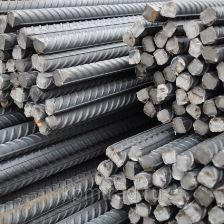

In [28]:
# example of original photo
from PIL import Image 

print('Image:', images[10])
Image.open(images_dir + images[10])

Density map for: 327168227_w640_h640_dsc_0541.h5
Number of armatures ~ 81.0


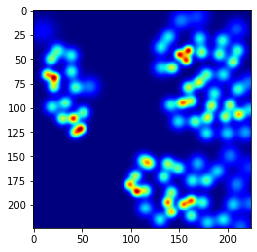

In [39]:
# example of density map 
h5_path = 'armatura_croped/hdf5/'
file_path = os.listdir(h5_path)
gt_file = h5py.File(h5_path + file_path[16],'r')
groundtruth = np.asarray(gt_file['density'])
print('Density map for:', file_path[16])
plt.imshow(groundtruth,cmap=CM.jet)
print("Number of armatures ~" ,round(np.sum(groundtruth)))

# Model

In [40]:
def armaturaCounting():
    
    rows = None
    cols = None

    batch_norm = 0
    kernel = (3, 3)
    init = RandomNormal(stddev=0.01)
    model = Sequential() 
    
    model.add(Conv2D(64, kernel_size = kernel, input_shape = (224,224,3),activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=2))
    model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=2))
    model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=2))            
    model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    
    
   
    model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))

    sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
    model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])

    model = init_weights_vgg(model)

    return model


def init_weights_vgg(model):
    
    json_file = open('model/VGG_16.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("weights/VGG_16.h5")
    
    vgg = loaded_model
    
    vgg_weights=[]                         
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
        
    offset=0
    i=0
    while(i<10):
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
            
        else:
            offset=offset+1

    return (model)

def create_img(paths):
    
    images = []
    for path in paths: 
        im = Image.open(path).convert('RGB')

        im = np.array(im)

        im = im/255.0

        im[:,:,0]=(im[:,:,0]-0.485)/0.229
        im[:,:,1]=(im[:,:,1]-0.456)/0.224
        im[:,:,2]=(im[:,:,2]-0.406)/0.225

        images.append(im)
        
    return np.array(images)

def get_input(path):
    
    img = create_img(path)
    return np.array(img)
    
    
    
def get_output(paths):
    
    images = []
    for path in paths:
        gt_file = h5py.File(path,'r')

        target = np.asarray(gt_file['density'])

        img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
        img = np.expand_dims(img,axis  = 3)
    
        images.append(img)
        
    return np.array(images)
    
def get_dataset(paths, batch_size=20):
    
    while True:
        
        input_path = np.random.choice(a = paths, size = batch_size, replace=False)
        
        name = [i.split('/')[-1].replace('.jpg', '.h5').replace('.jpeg', '.h5') for i in input_path] # .replace('.jpg', '.hdf5').replace('.jpeg', '.hdf5')
        hdf5_paths = ['/'.join(input_path[i].split('/')[:-1]) + '/hdf5/' + name[i] for i in range(len(input_path))]
        batch_input = []
        batch_output = [] 
        
        
        inputt = get_input(input_path) 
        output = get_output(hdf5_paths)

        batch_x = inputt
        batch_y = output
                        
        yield (batch_x, batch_y)

In [55]:
def save_model_weights(model , weigths , own_model):
    model.save_weights(weigths)
    
    model_json = model.to_json()
    
    with open(own_model, "w") as json_file:
        json_file.write(model_json)
        
def load_model_weights():

    json_file = open('model/armaturaNet_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("weights/armaturaNet_weights.h5")
    return loaded_model

In [41]:
model = armaturaCounting()
model.summary()

W1010 12:37:13.408341 140255130498880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 128)    

In [42]:
image_path = 'armatura_croped/'
img_paths = [image_path + i for i in os.listdir('armatura_croped/') if i.endswith('.jpg') or i.endswith('.jpeg')] 
train = get_dataset(img_paths)

In [43]:
sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
model.compile(optimizer=sgd, loss='mae', metrics=['mse'])

In [44]:
model.fit_generator(train,epochs=2,steps_per_epoch= 30, verbose=1)

W1010 12:37:34.952335 140255130498880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/2
30/30 [==============================] - 648s 22s/step - loss: 0.2086 - mse: 0.2920
Epoch 2/2
30/30 [==============================] - 657s 22s/step - loss: 0.2047 - mse: 0.2826


In [54]:
save_model_weights(model,"weights/armaturaNet_weigths.h5","model/armaturaNet_model.json")

In [50]:
img = plt.imread('armatura_croped/6500c-600x600.jpg')
predicted_density_map = model.predict(img.reshape(1, 224, 224, 3))
print('Predicted number of armatures:', round(np.sum(predicted_density_map)))
print('True number of armatures: {0}'.format(33))

Predicted number of armatures: 40.0
True number of armatures: 33


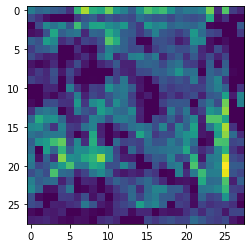

In [49]:
plt.imshow(predicted_density_map.reshape(28,28))
plt.show()

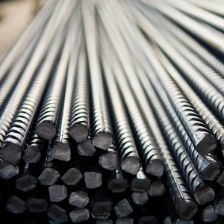

In [47]:
Image.open('armatura_croped/6500c-600x600.jpg')